The main idea is to see the features and the steps as an image thanks to the large amount of informations with the features. We will need to add a channel dimension in the input layer of the model with a shape = (none,60,158,1)

MODEL PLOT With 3 Blocks, Shortcut and Conv2D :

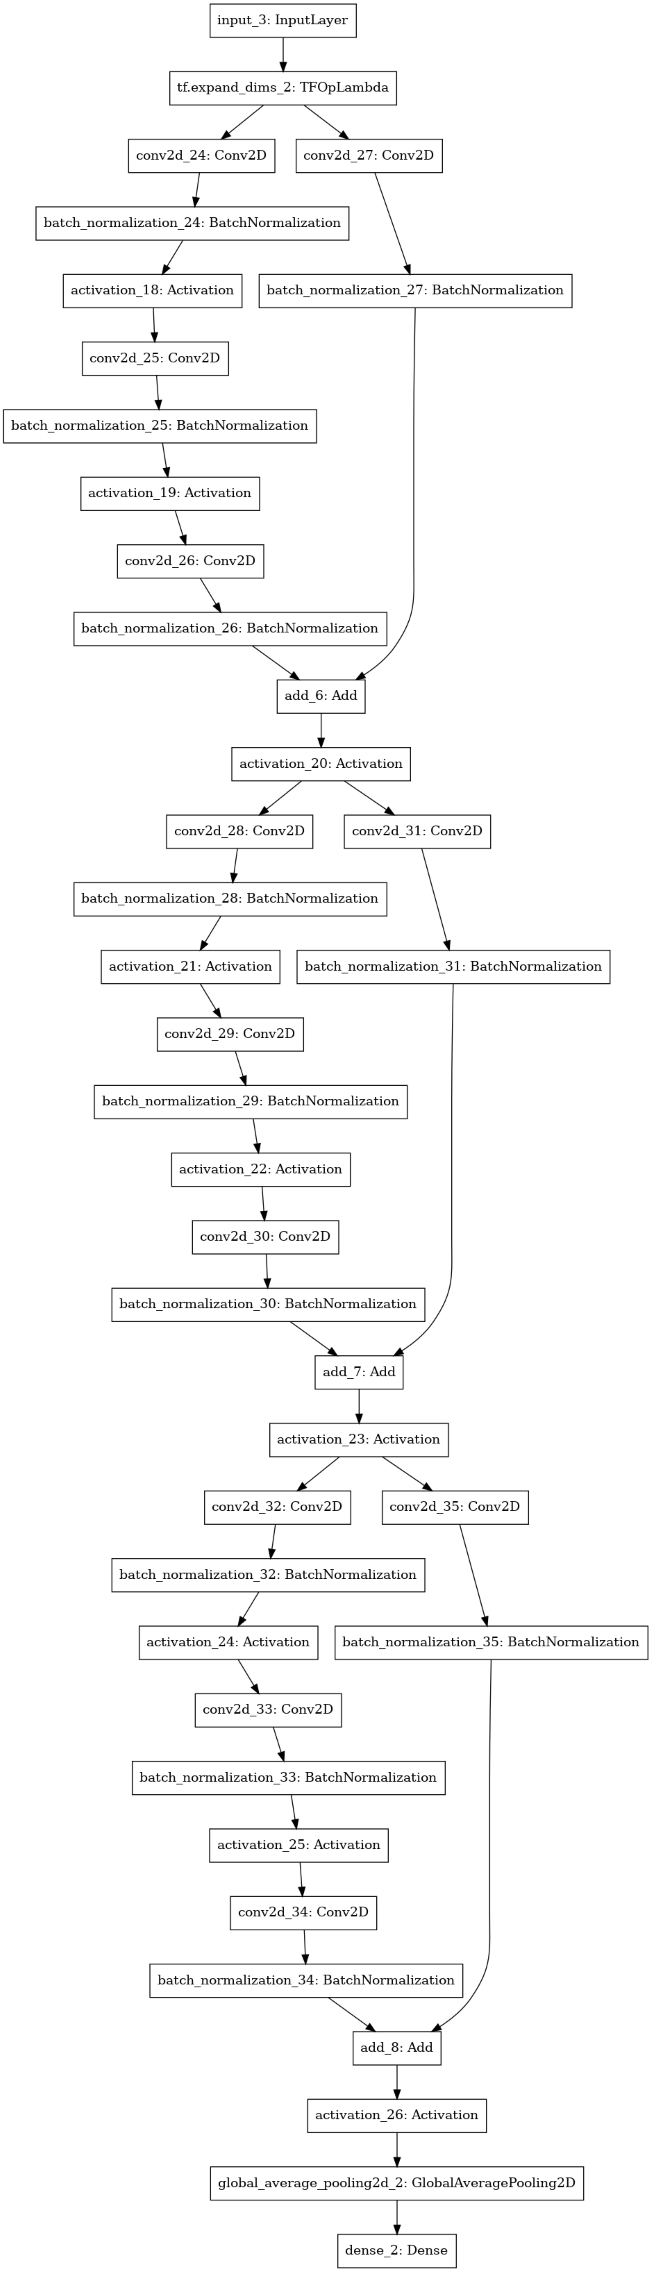

In [ ]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
#from tensorflow.keras import mixed_precision

from sklearn.model_selection import GroupKFold
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

import scipy.stats  
import gc

import warnings
warnings.filterwarnings("ignore")


In [ ]:
train = pd.read_csv('../input/tabular-playground-series-apr-2022/train.csv').astype('float32')
labels = pd.read_csv('../input/tabular-playground-series-apr-2022/train_labels.csv')
test = pd.read_csv('../input/tabular-playground-series-apr-2022/test.csv').astype('float32')
FEATURES = [col for col in train.columns if 'sensor' in col]
train.shape,test.shape

In [ ]:
gc.collect()

<h2> Groups for training

In [ ]:
groups = train.pivot(index = ['sequence','subject'],columns = 'step',values = FEATURES).index.get_level_values('subject')

<h2> Pre-processing data

In [ ]:
def pre_process(df):
    
    # Sensors stats :
    
    dico =dict()
    dico = dict(zip(df.groupby('sequence')['sensor_02'].mean().index,df.groupby('sequence')['sensor_02'].mean()))
    df['sensor_02' +'_mean'] = df['sequence'].map(dico)

    dico = dict(zip(df.groupby('sequence')['sensor_02'].std().index,df.groupby('sequence')['sensor_02'].std()))
    df['sensor_02' +'std'] = df['sequence'].map(dico)
               
    dico = dict(zip(df.pivot(index=['sequence'], columns='step', values='sensor_04').index.tolist(),
    scipy.stats.kurtosis(df.pivot(index=['sequence'], columns='step', values='sensor_04'), axis=1)))
    df['sensor_04' +'kurtosis'] = df['sequence'].map(dico)  
    
    # Tracking the Sequences per Subject correlation with target :
    
    dico = dict(zip(df.groupby('subject')['sequence'].count().index,100/df.groupby('subject')['sequence'].count()))
    df['curve_100'] = df['subject'].map(dico)
               
    dico = dict(zip(df.groupby('subject')['sequence'].count().index,200/df.groupby('subject')['sequence'].count()))
    df['curve_200'] = df['subject'].map(dico)
                
    dico = dict(zip(df.groupby('subject')['sequence'].count().index,300/df.groupby('subject')['sequence'].count()))
    df['curve_300'] =  df['subject'].map(dico)
                
    dico = dict(zip(df.groupby('subject')['sequence'].count().index,400/df.groupby('subject')['sequence'].count()))
    df['curve_400'] =  df['subject'].map(dico)
                
    dico = dict(zip(df.groupby('subject')['sequence'].count().index,500/df.groupby('subject')['sequence'].count()))
    df['curve_500'] =  df['subject'].map(dico)
                
    dico = dict(zip(df.groupby('subject')['sequence'].count().index,600/df.groupby('subject')['sequence'].count()))
    df['curve_600'] =  df['subject'].map(dico)
                
    dico = dict(zip(df.groupby('subject')['sequence'].count().index,700/df.groupby('subject')['sequence'].count()))
    df['curve_700'] =  df['subject'].map(dico)
                
    dico = dict(zip(df.groupby('subject')['sequence'].count().index,800/df.groupby('subject')['sequence'].count()))
    df['curve_800'] =  df['subject'].map(dico)
                
    dico = dict(zip(df.groupby('subject')['sequence'].count().index,900/df.groupby('subject')['sequence'].count()))
    df['curve_900'] =  df['subject'].map(dico)
                
    dico = dict(zip(df.groupby('subject')['sequence'].count().index,1000/df.groupby('subject')['sequence'].count()))
    df['curve_1000'] =  df['subject'].map(dico)
                
    dico = dict(zip(df.groupby('subject')['sequence'].count().index,1100/df.groupby('subject')['sequence'].count()))
    df['curve_1100'] =  df['subject'].map(dico)
                
    dico = dict(zip(df.groupby('subject')['sequence'].count().index,1200/df.groupby('subject')['sequence'].count()))
    df['curve_1200'] =  df['subject'].map(dico)
    
    # Sensors lags (as usual for time series) :
                
    for feature in FEATURES:

        df[feature + '_lag1'] = df.groupby('sequence')[feature].shift(1).fillna(0)
        df[feature + '_lag2'] = df.groupby('sequence')[feature].shift(2).fillna(0)
        df[feature + '_lag3'] = df.groupby('sequence')[feature].shift(3).fillna(0)
        df[feature + '_back1'] = df.groupby('sequence')[feature].shift(-1).fillna(0)

        df[feature + '_mean1'] = df[feature]/2 + df[feature + '_lag1']/2
        df[feature + '_mean2'] = df[feature]/3 + df[feature + '_lag1']/3 + df[feature + '_lag2']/3
        df[feature + '_mean3'] = df[feature]/4 + df[feature + '_lag1']/4 + df[feature + '_lag2']/4 + df[feature + '_lag3']/4

        df[feature + '_diff1'] = df[feature] - df[feature + '_lag1']
        df[feature + '_diff2'] = df[feature] - df[feature + '_lag2']
        df[feature + '_diff3'] = df[feature] - df[feature + '_lag3']

        df[feature + '_back1'] = df[feature] - df[feature + '_back1']           
                
    return df

In [ ]:
train = pre_process(train)
test = pre_process(test)
train.shape, test.shape, train.isnull().sum().sum(), test.isnull().sum().sum()

In [ ]:
gc.collect()

<h2> Data reshaping for multivariate sequences

In [ ]:
train = train.drop([
                    "sequence", 
                    "subject",
                    "step"], 
                    axis=1).values
test = test.drop([
                    "sequence",
                    "subject",
                    "step"], 
                    axis=1).values
reshape = train.shape

labels = labels["state"]
train = train.reshape(
                    int(len(train)/60),
                    60,
                    reshape[1]) 
test = test.reshape(
                    int(len(test)/60),
                    60,
                    reshape[1])     

train.shape,test.shape

In [ ]:
gc.collect()

<h2> Resnet Model

In [ ]:
def model_NN0():
    
    # ****************** RESNET MODEL with Conv2D *****************
    
    # Filters per Block :
    A = 24
    B = 32
    C = 32
    
    # Kernels per Block :
    # -> Block 1
    a1 = (10,3)
    b1 = (7,3)
    c1 = (3,3)

    # -> Block 2
    a2 = (10,3)
    b2 = (7,3)
    c2 = (3,3)
    
    # -> Block 3 
    a3 = (10,3)
    b3 = (7,3)
    c3 = (3,3)

    # Strides for all blocks :
    s = (1,1)
     
    input_layer = tf.keras.layers.Input(shape = (train.shape[-2:]))
    
    # Reshaping with additional channel for CONV2D :
    input_layer1 = tf.keras.backend.expand_dims(input_layer,axis = -1)
    
    # ------------------- BLOCK 1 ----------------------
    conv_x = keras.layers.Conv2D(
                                filters = A,
                                kernel_size = a1,
                                strides = s,
                                padding ='same')(input_layer1) 
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)
    
    conv_y = keras.layers.Conv2D(
                                filters = A,
                                kernel_size = b1,
                                strides = s,
                                padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)
    
    conv_z = keras.layers.Conv2D(
                                filters = A,
                                kernel_size = c1,
                                strides = s,
                                padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)
    
    # Number of Filters aligned for addition with input_layer1 :
    shortcut_y = keras.layers.Conv2D(
                                filters = A,
                                kernel_size = 1,
                                padding='same')(input_layer1) 
    
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y) 
    
    output_block_1 = keras.layers.add(
                                [shortcut_y, 
                                conv_z
                                ])
    output_block_1 = keras.layers.Activation('relu')(output_block_1)
    
        
    # ------------------- BLOCK 2 ----------------------
    conv_x = keras.layers.Conv2D(
                                filters = B,
                                kernel_size = a2,
                                strides = s,
                                padding='same')(output_block_1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv2D(
                                filters = B,
                                kernel_size = b2,
                                strides = s,
                                padding = 'same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv2D(
                                filters = B,
                                kernel_size = c2,
                                strides = s,
                                padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)
    
    shortcut_y = keras.layers.Conv2D(
                                filters = B,
                                kernel_size = 1,
                                padding = 'same')(output_block_1)
    
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
  
    output_block_2 = keras.layers.add([
                                shortcut_y,
                                conv_z
                                      ])
    output_block_2 = keras.layers.Activation('relu')(output_block_2)
    
    # ------------------- BLOCK 3 ----------------------
    conv_x = keras.layers.Conv2D(
                                filters = C,
                                kernel_size = a3,
                                strides = s,
                                padding = 'same')(output_block_2) 
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv2D(
                                filters = C,
                                kernel_size = b3,
                                strides = s,
                                padding = 'same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv2D(
                                filters = C,
                                kernel_size = c3,
                                strides = s,
                                padding = 'same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    shortcut_y = keras.layers.Conv2D(
                                filters = C,
                                kernel_size = 1,
                                padding = 'same')(output_block_2)

    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_3 = keras.layers.add([
                                shortcut_y, 
                                conv_z
                                      ])
    output_block_3 = keras.layers.Activation('relu')(output_block_3)
    
    # ------------------- FINAL STEP ----------------------
    
    gap_layer = keras.layers.GlobalAveragePooling2D()(output_block_3)
    output_layer = keras.layers.Dense(1, activation = 'sigmoid')(gap_layer)
    
    model = tf.keras.Model(input_layer,output_layer)
    
    return model

In [ ]:
gc.collect()

<h2> Training

In [ ]:
# It is recommended to use a TPU Strategy...

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    BATCH_SIZE = tpu_strategy.num_replicas_in_sync * 16
    print("Running on TPU:", tpu.master())
    print(f"Batch Size: {BATCH_SIZE}")
    
except ValueError:
    strategy = tf.distribute.get_strategy()
    BATCH_SIZE = 128
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    print(f"Batch Size: {BATCH_SIZE}")
    
with tpu_strategy.scope():

# Without TPU :
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_global_policy(policy)


RUN = 3 
N_SPLIT = 15
EPOCH = 13
VERBOSE = 0

LOSS = tf.keras.losses.BinaryCrossentropy()
METRIC = tf.keras.metrics.AUC(name = 'auc')

es = [tf.keras.callbacks.EarlyStopping(
                                monitor = 'val_auc',
                                patience = 15,
                                mode = 'auto',
                                min_delta = 1e-12,
                                verbose = VERBOSE),
tf.keras.callbacks.ModelCheckpoint(
                                'testmodel.h5',
                                monitor = 'val_auc',
                                save_weights_only = True,
                                mode = 'auto')]


plateau = tf.keras.callbacks.ReduceLROnPlateau(
                                monitor = 'val_auc',
                                factor = 0.1,
                                patience = 3,
                                verbose = VERBOSE,
                                mode = 'auto')

# For all run OOFs and test prediction :
blend_train_all = np.zeros((train.shape[0], RUN))
blend_test = np.zeros((test.shape[0], RUN))

kf = GroupKFold(n_splits = N_SPLIT)

# Multiple runs to enable multiple shuffle for subjects :
for i in range(RUN):

    print("_"*20, "RUN n°",i+1, "_"*20)

    index = np.arange(0,train.shape[0])
    blend_train_run = np.zeros(train.shape[0])

    #-------------------- SHUFFLE -------------------------
    new_index, X_shuffled,  y_shuffled, groups_shuffled = shuffle(
                                                    index,
                                                    train, 
                                                    labels,
                                                    groups, 
                                                    random_state=(i+1)*i)
    #y_shuffled.sort_index()


    for fold_idx, (train_idx, valid_idx) in enumerate(kf.split(
                                                    X_shuffled,
                                                    y_shuffled,
                                                    groups_shuffled )):

        print()
        print("-"*15, f"Fold {fold_idx+1}", "-"*15)

        X_train = X_shuffled[train_idx]   
        X_valid = X_shuffled[valid_idx]
        y_train = y_shuffled.iloc[train_idx].values 
        y_valid = y_shuffled.iloc[valid_idx].values

        # Reshapping for Standardization:
        X_train = X_train.reshape(
                                len(train_idx) * 60,
                                X_train.shape[2])
        X_valid= X_valid.reshape(
                                len(valid_idx) * 60,
                                 X_valid.shape[2])
        test_sc = test.reshape(
                                test.shape[0] * 60,
                                test.shape[2]) 

        rob = StandardScaler()

        X_train = rob.fit_transform(X_train)
        X_valid = rob.transform(X_valid)
        test_sc = rob.transform(test_sc)

        X_train = X_train.reshape(
                                int(X_train.shape[0] / 60),
                                60, X_train.shape[1])
        X_valid = X_valid.reshape(
                                int(X_valid.shape[0] / 60),
                                60, 
                                X_valid.shape[1])
        test_sc = test_sc.reshape(
                                int(test_sc.shape[0] / 60),
                                60, 
                                test_sc.shape[1])


        #======== Model instantiation =================

        model00 = model_NN0() 
        model00.compile(
            optimizer = keras.optimizers.Adam(learning_rate=0.001),
            loss=LOSS, 
            metrics=METRIC)
        model00.fit(
                    X_train,
                    y_train, 
                    validation_data = (X_valid, 
                                       y_valid), 
                    epochs = EPOCH, 
                    batch_size = 128,
                    verbose = VERBOSE, 
                    callbacks = [es, plateau])

        model00.load_weights('testmodel.h5')

        pred = model00.predict(X_valid)
        score00 = roc_auc_score(y_valid,pred)

        print("\nSCORE model00 = {}".format(np.round(score00,4)))

        blend_train_run[valid_idx] = (pred).squeeze()

        pred = model00.predict(test_sc).squeeze()
        blend_test[:,i] += (pred/(N_SPLIT))

        del X_train, X_valid, test_sc, rob
        gc.collect()

    # For Total run OOF score :
    blend_train_all[:,i] = pd.DataFrame(
                        blend_train_run,
                        index=new_index).sort_index().values.squeeze()

    # For current run OOF score :
    score00 = roc_auc_score(
                            labels, 
                            pd.DataFrame(
                            blend_train_run,
                            index=new_index).sort_index())  

    print('\n******* OOF SCORE RUN {} = {} *******\n'.format(i+1,score00))

total_score00 = roc_auc_score(labels, 
                              blend_train_all.mean(axis=1))
print('\n',60*'*') 
print('\nOOF total model 00 = ',total_score00)

<h2> You will achieve AUC = 0.984, then re-train with a new shuffle random_state, and blend the 2 trainings => 0.987